# Evaluate MLP and CNN models

Inspired by: https://blog.paperspace.com/deep-learning-metrics-precision-recall-accuracy/ and https://bytepawn.com/solving-mnist-with-pytorch-and-skl.html

In [1]:
import os
import torch
import torch.nn.functional as F
import sklearn.metrics as skm
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from helpers.mnist_loader import loadMNISTDatasets, getMNISTLoaders
import helpers.evaluation as evaluation

import models.MLP as MLPs
import models.CNN as CNNs

/home/william/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
matplotlib.rcParams['figure.figsize'] = (10, 5)

In [3]:
train_dataset, val_dataset, holdback_dataset = loadMNISTDatasets()
_,_, holdback_loader = getMNISTLoaders([train_dataset, val_dataset, holdback_dataset],batch_size=1000)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Select the model below to evaluate

In [5]:
# Must be in models/saved
model = MLPs.MLPZero().to(device)
evaluation.loadModel(model, 'MLPZero');

# Must be in results
training_file = "zero.csv"

#### Calculate per class confusion matrices

In [6]:
cms = evaluation.ComputeConfusionMatrices(model, holdback_loader)

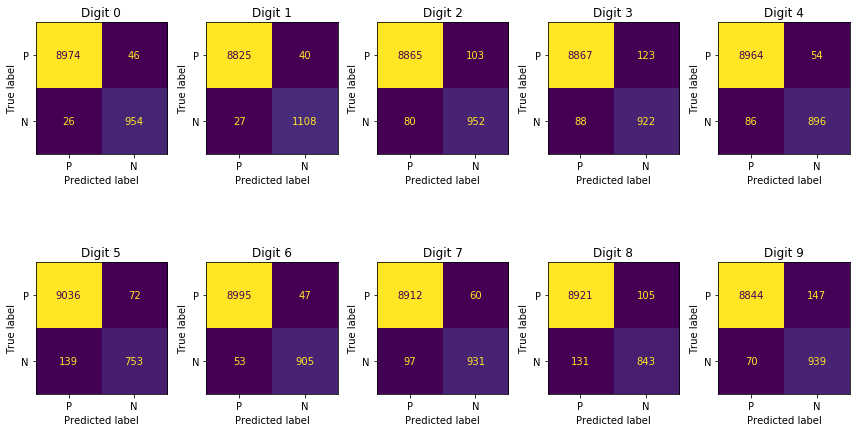

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(12, 7))
    
for cm, axes, title in zip(cms, ax.flatten(), list(range(10))):
    axes.title.set_text(f'Digit {title}')
    skm.ConfusionMatrixDisplay(cm, display_labels=['P', 'N']).plot(ax=axes, colorbar=False)

fig.tight_layout()
plt.show()

#### Calculate basic performance metrics per class

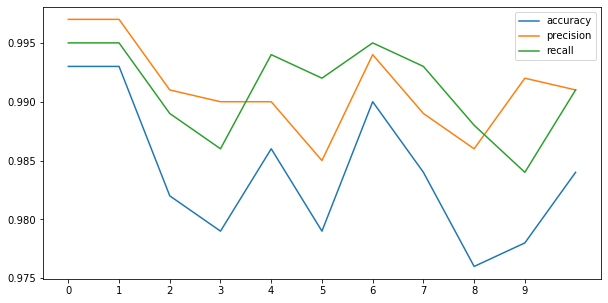

In [8]:
result = evaluation.getPerformanceMetrics(cms)
result[['accuracy', 'precision', 'recall']].plot(xticks=[0,1,2,3,4,5,6,7,8,9])
plt.show()

In [9]:
result

,accuracy,precision,recall,f1
0,0.993,0.997,0.995,0.498
1,0.993,0.997,0.995,0.498
2,0.982,0.991,0.989,0.495
3,0.979,0.990,0.986,0.494
4,0.986,0.990,0.994,0.496
5,0.979,0.985,0.992,0.494
6,0.990,0.994,0.995,0.497
7,0.984,0.989,0.993,0.496
8,0.976,0.986,0.988,0.493
9,0.978,0.992,0.984,0.494


#### Check learning progress based on the output file of the training notebook

In [10]:
if not os.path.exists(f'results/{training_file}'):
    print('ERROR missing training file! Try retraining to produce the needed file!')
else:
    model_training_log = pd.read_csv(f'results/{training_file}', index_col=0, usecols=[0,1,2,3,4,5,6])
    model_training_log.head()

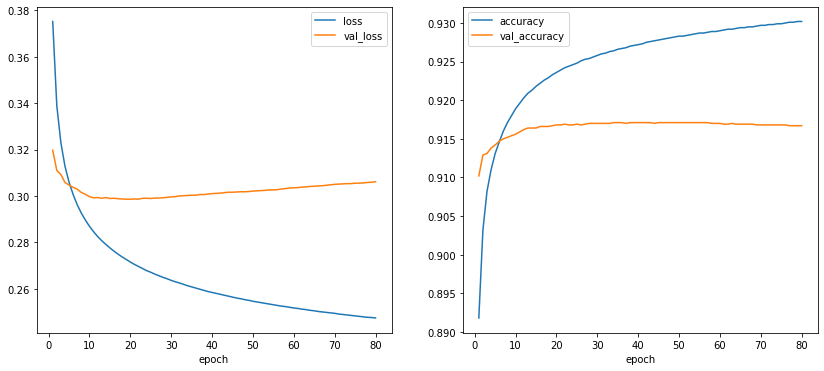

In [11]:
if not os.path.exists(f'results/{training_file}'):
    print('ERROR missing training file! Try retraining to produce the needed file!')
else:
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    model_training_log.plot(x='epoch', y=['loss', 'val_loss'], ax=axs[0])
    model_training_log.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=axs[1])
    plt.show()

#### Validate accuracy on holdback dataset

In [12]:
evaluation.validate(model, F.cross_entropy, holdback_loader)


HoldBackSet: Avg. loss: 0.0003, Accuracy: 0.9203 (92.0%)



#### ROC curve and AOC

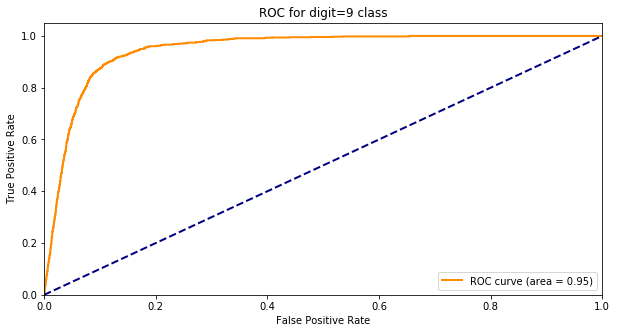

In [13]:
which_class = 9
actuals, class_probabilities = evaluation.test_class_probabilities(model, holdback_loader, which_class)

fpr, tpr, thresholds = skm.roc_curve(actuals, class_probabilities)
roc_auc = skm.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [18]:
fpr

array([0.00000000e+00, 0.00000000e+00, 2.22444667e-04, ...,
       6.55433211e-01, 6.55433211e-01, 1.00000000e+00])